# Question 1: Tree-based Classifiers and Ensembles
## Part 1, Dataset 1 (Wheat Seeds)
This part of the report contains the preprocessing of the first dataset for use in tree based classification, as well as the implementation of the tree based classifiers to predict type of wheat seed based on given physical characteristics. The testing of the implementations were done on a separated out testing set (20% of dataset), while the training was likewise done on the training set (80% of dataset). In the process, the data was also visualized to decide on feature selection (to avoid biasing the classifier if the variables are too correlated). The results of training both with and without feature selection are given in the report. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing:
The steps taken to preprocess the data are broadly:

1. Correcting the right-shifted data entries, which was noticed by visual observation of the dataset. Upon application of a correction algorithm, all the values fall in place without outliers (except which were naturally present)

2. Check and delete any negative values (all values are physical dimension measurements)

3. Check for univariate outliers using boxplot (from the seaborn library) and confirm using z-score (from scipy.stats); Remove confirmed outliers

4. Check for strong correlation using the pairplot and heatmap of the feature correlations (heatmap using seaborn); Check both cases-> classification with all features, and with reduced number of features.

In [2]:
#Read text file:
df = pd.read_csv('seeds_dataset.txt', sep="\t", names=list('abcdefghjk'))

#Fill NaN (missing) entries with -1 for ease of operation"
df.fillna(-1,inplace=True)

In [3]:
#To correct wrong data entries as observed (row entries shifted right by one or two columns)
for i in range(len(df)-1):
    if df.c[i]==-1:
        if df.d[i]!=-1:
            df.c[i]=df.d[i]
            df.d[i]=-1
        else:
            df.c[i] = df.e[i]
            df.e[i]=-1
            
    if df.d[i]==-1:
        if df.e[i]!=-1:
            df.d[i]=df.e[i]
            df.e[i]=-1
        else:
            df.d[i] = df.f[i]
            df.f[i]=-1
                        
    if df.e[i]==-1:
        if df.f[i]!=-1:
            df.e[i]=df.f[i]
            df.f[i]=-1
        else:
            df.e[i] = df.g[i]
            df.g[i]=-1
            
    if df.f[i]==-1:
        if df.g[i]!=-1:
            df.f[i]=df.g[i]
            df.g[i]=-1
        else:
            df.f[i] = df.h[i]
            df.h[i]=-1
            
    if df.g[i]==-1:
        if df.h[i]!=-1:
            df.g[i]=df.h[i]
            df.h[i]=-1
        else:
            df.g[i] = df.j[i]
            df.j[i]=-1
            
    if df.h[i]==-1:
        if df.j[i]!=-1:
            df.h[i]=df.j[i]
        else:
            df.h[i]=df.k[i]

#Remove the excess last rows:
df = df.drop(columns=['j','k'])

In [4]:
#Apply proper column names:
df.columns=['area','perimeter','compactness','length_kernel','width_kernel','asymmetry_coeff','length_of_kernel_groove','target']
df.head()

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_of_kernel_groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1.0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1.0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1.0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1.0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1.0


In [5]:
#Verify if any entries are missing:
df.isnull().sum()

area                       0
perimeter                  0
compactness                0
length_kernel              0
width_kernel               0
asymmetry_coeff            0
length_of_kernel_groove    0
target                     0
dtype: int64

In [6]:
#If any negative values are present, delete row:
df_temp = df
df_temp = df_temp.reset_index()
df_temp.rename(columns={'index':'old_id'},inplace=True)
molten = pd.melt(df_temp, var_name='column', id_vars='old_id')
neg_rows = molten[molten.value<0].old_id.to_list()
for i in neg_rows:    
    df.drop([i])

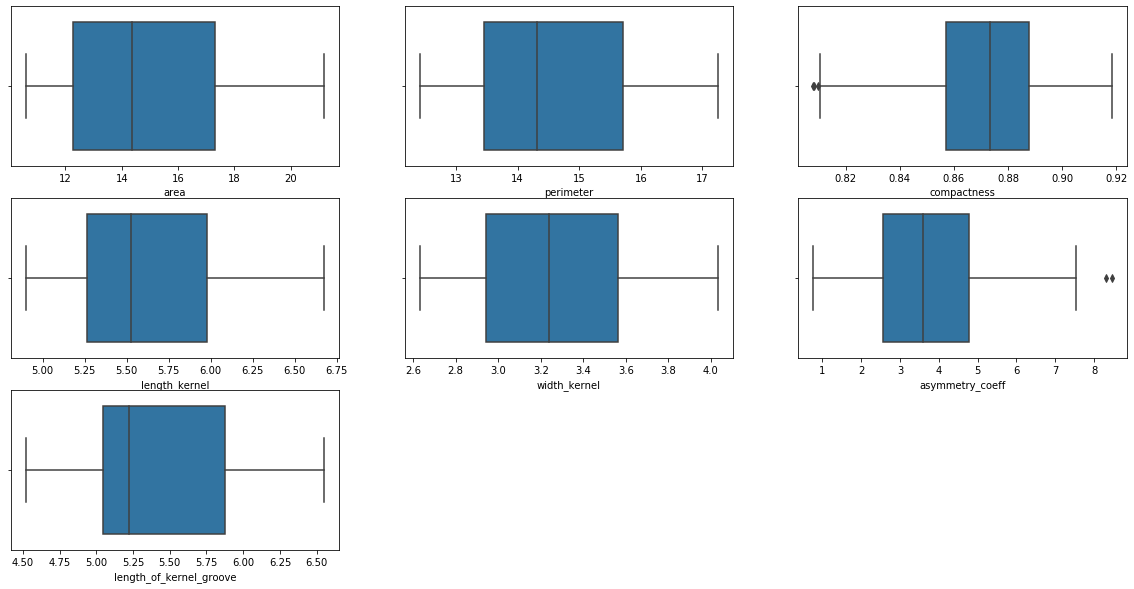

In [7]:
#Find and remove outliers if any:
#First, by boxplot
fig = plt.figure(figsize=(20,10))
fig.add_subplot(3,3,1)
sns.boxplot(df['area'])
fig.add_subplot(3,3,2)
sns.boxplot(df['perimeter'])
fig.add_subplot(3,3,3)
sns.boxplot(df['compactness'])
fig.add_subplot(3,3,4)
sns.boxplot(df['length_kernel'])
fig.add_subplot(3,3,5)
sns.boxplot(df['width_kernel'])
fig.add_subplot(3,3,6)
sns.boxplot(df['asymmetry_coeff'])
fig.add_subplot(3,3,7)
sns.boxplot(df['length_of_kernel_groove']);

From the plots above, univariate outliers can be observed in the 'compactness' and 'asymmetry_coeff' features. To further verify is these are true outliers, z-score method is used, which is a measure of the number of standard deviations the value is from the mean. 

In [8]:
#To verify outliers, use z-score to get any outliers (taking threshold = 3):
from scipy import stats
z = np.abs(stats.zscore(df))
print(np.where(z > 3))

(array([203, 207], dtype=int64), array([5, 5], dtype=int64))


Confirming that two of the identified outliers, both in the 'asymmetry_coeff' variable are true outliers, the two entries containing them are removed from the dataset.

In [9]:
#Remove rows 203 and 207, keep rows with compactness outliers
df = df.drop([203,207])

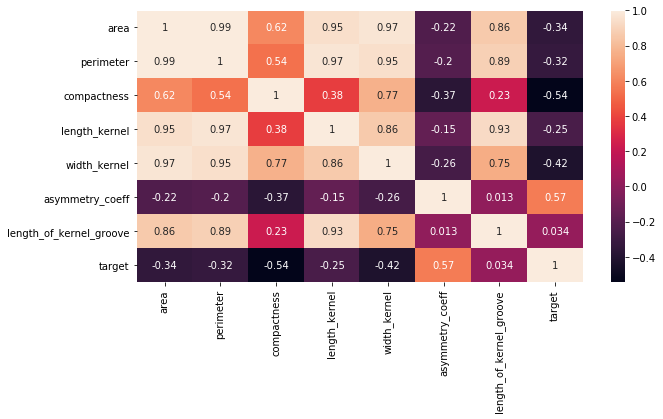

In [10]:
#Checking for correlation:
df_corr = df.corr(method='pearson')
fig = plt.figure(figsize=(10,5))
sns.heatmap(df_corr,annot=True);

From the heat plot above, the perimeter and area can be seen to have very tight correlation, as well as kernel length and kernel width to a lesser degree. From the table, it is also clear that the relationships of the area and perimeter with the other variables are quite similar. There is a possibility that dropping the perimeter variable could imporve the tree classifier performance. The results of such column dropping are shown after the decision tree segment.

### On normalization: 
Since decision trees and tree-based classifiers in general work on values of the parameters, any scaling applied on the entire dataset (when all values are positive) will only yield the exact same results as the one without scaling. 

## Getting the training and testing datasets:
Note: As 10-fold cross-validation is used to train the classifiers, no separate validation set is required, hence only one split of the data is required. 20% of the data was taken as the test set, and the rest form the training set. The results of the split show that distribution of the three different target outcomes are split somewhat evenly in the training set (and thus the testing set).

In [11]:
X = df.drop(columns=['target'])
y = df['target'].to_list()

#Splitting Training and Testing Data:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [12]:
atest = [str(i) for i in y_train]
defy = pd.DataFrame(atest,columns=['col'])
defy.col.value_counts()

1.0    57
3.0    55
2.0    54
Name: col, dtype: int64

## Decision Tree:
The decision tree classifier used is from the sklearn.tree library. First, the classifier was 'fit' to the training data and tested for accuracy on the testing set with all default parameters except random_state (for repeatability). This is used as a baseline for tuning. 

In [13]:
#Decision Tree Baseline:
from sklearn import tree
from sklearn import metrics

dt0 = tree.DecisionTreeClassifier(random_state=0)

dt_0 = dt0.fit(X_train,y_train)
y_0 = dt0.predict(X_test)
#Get accuracy score of model:
accuracy = metrics.accuracy_score(y_test,y_0)
accuracy

0.9047619047619048

Checking for noticable differences in the estimator accuracy after different normalization and scaling methods, there were no differences found as expected from a tree based classifier. After this confirmation, no normalization is done for the other methods:

In [14]:
#Compare with normalized data:
from sklearn import preprocessing

mmscaler = preprocessing.MinMaxScaler()
stdscaler = preprocessing.StandardScaler()
normer = preprocessing.Normalizer()
mmscaler.fit(X_train)
stdscaler.fit(X_train)
normer.fit(X_train)

mm_X_train = mmscaler.transform(X_train)
mm_X_test = mmscaler.transform(X_test)
dt_01 = dt0.fit(mm_X_train,y_train)
y_01 = dt0.predict(mm_X_test)
#Get accuracy score of model:
acc01 = metrics.accuracy_score(y_test,y_01)

std_X_train = stdscaler.transform(X_train)
std_X_test = stdscaler.transform(X_test)
dt_02 = dt0.fit(X_train,y_train)
y_02 = dt0.predict(X_test)
#Get accuracy score of model:
acc02 = metrics.accuracy_score(y_test,y_02)

nor_X_train = normer.transform(X_train)
nor_X_test = normer.transform(X_test)
dt_03 = dt0.fit(X_train,y_train)
y_03 = dt0.predict(X_test)
#Get accuracy score of model:
acc03 = metrics.accuracy_score(y_test,y_0)

test_acc_labels = ['nothing','min max scaling','standardizing','normalizing']
test_acc = [accuracy,acc01,acc02,acc03]

norm_acc_table = pd.DataFrame({'method':test_acc_labels,'test_acc':test_acc})
norm_acc_table

,method,test_acc
0,nothing,0.904762
1,min max scaling,0.904762
2,standardizing,0.904762
3,normalizing,0.904762


To optimize the max_depth hyperparameter, sklearn's GridSearchCV function was used, with 10-fold cross validation, and set to optimize based on accuracy. The mean accuracy values for each max_depth is found and plotted against max_depth as required.

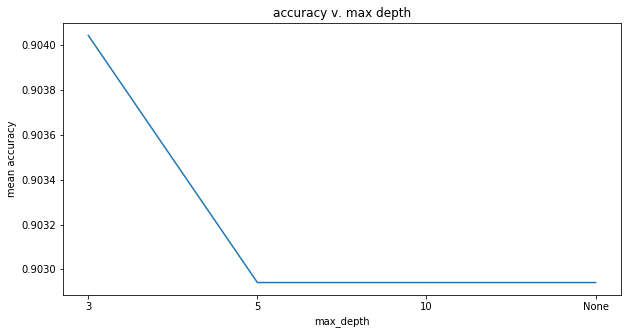

In [15]:
#Optimizing decision tree max_depth:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[3,5,10,None]}
dt = tree.DecisionTreeClassifier(random_state=0)
dt_clf = GridSearchCV(dt,parameters,scoring='accuracy',cv=10)
dt_clf.fit(X_train,y_train)


means = dt_clf.cv_results_['mean_test_score']
maxdepth = ['3','5','10','None']
fig = plt.figure(figsize=(10,5))
plt.plot(maxdepth,means)
plt.xlabel('max_depth')
plt.ylabel('mean accuracy')
plt.title('accuracy v. max depth');

In [16]:
dt_clf.best_params_

{'max_depth': 3}

From the above, the best parameter max_depth was found to be 3. The tree is plotted below for analysis.

In [17]:
#Accuracy of model from testing set:
dtf = tree.DecisionTreeClassifier(max_depth=3,random_state=0)
dtf.fit(X_train,y_train)
y_pred = dtf.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred)
accuracy

0.9047619047619048

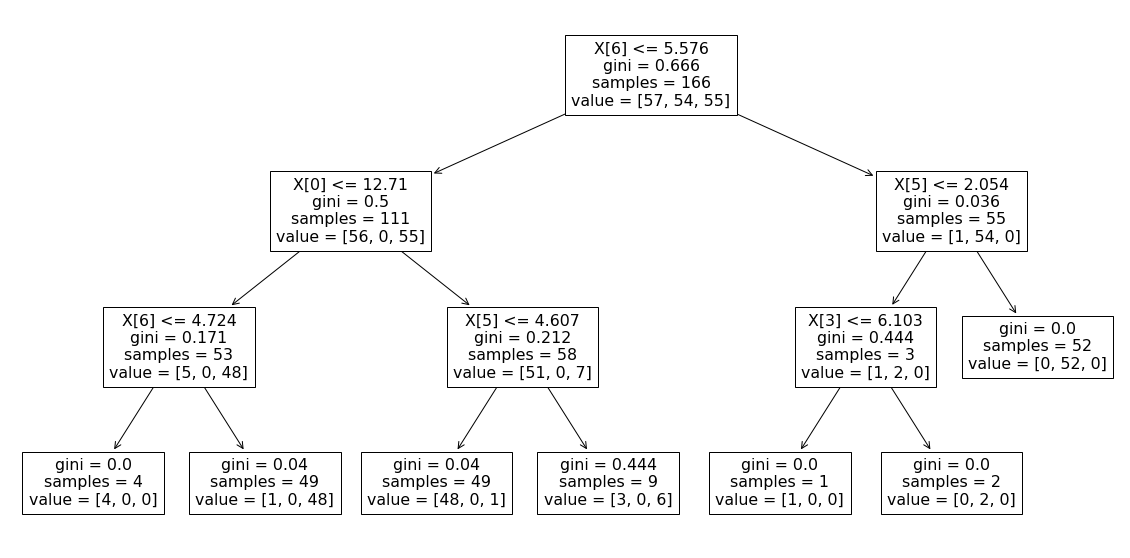

In [18]:
#Plotting the tree with best parameters:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(dtf);

The most important feature for tree splitting as observed from the plot is feature 6- length of the kernel groove. This is reinforced by the ranking given below based on features' reduction of the gini value (disorder measure). As expected from the correlation plots, some of the features seemed redundant or irrelevant to the outcome labels.

Feature: 0, Score: 0.33225
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01298
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.06797
Feature: 6, Score: 0.58681


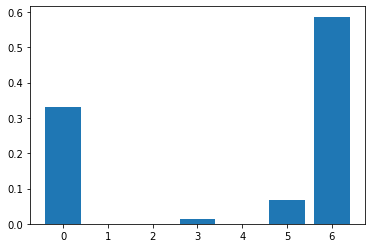

In [19]:
importance = dtf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Decision tree training after feature selection:
The features 1,2, 3 and 4 (Perimeter, compactness, and kernel width) are removed to check if the tree performance is improved. 

In [51]:
X_train1 = X_train.drop(columns=['perimeter','compactness','width_kernel'])
X_test1 = X_test.drop(columns=['perimeter','compactness','width_kernel'])

dtf = tree.DecisionTreeClassifier(max_depth=3,random_state=0)
dtf.fit(X_train1,y_train)
y_pred = dtf.predict(X_test1)
accuracy = metrics.accuracy_score(y_test,y_pred)
accuracy

0.9285714285714286

There is a noticable increase in accuracy with reduction in features-> from 90.5% to 92.9%.

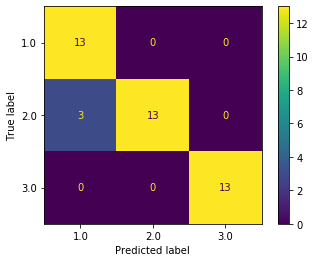

In [63]:
#Confusion matrix for decision tree
cm = metrics.confusion_matrix(y_test, yA,labels=dtf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dtf.classes_)
disp.plot();

## Random Forest:

In [21]:
#Random Forest Baseline:
from sklearn.ensemble import RandomForestClassifier

rf0 = RandomForestClassifier(random_state=0)

rf_0 = rf0.fit(X_train,y_train)
y_0 = rf0.predict(X_test)
#Get accuracy score of model:
accuracy = metrics.accuracy_score(y_test,y_0)
accuracy

0.9523809523809523

In [22]:
#Optimizing parameters for random forests:
parameters = {'n_estimators':[5,10,50,150,200],'max_depth':[3,5,10,None]}
rf = RandomForestClassifier(random_state=0)
rf_clf = GridSearchCV(rf,parameters,scoring='accuracy',cv=10)
rf_clf.fit(X_train,y_train)
means = rf_clf.cv_results_['mean_test_score']

In [23]:
#Setting up dataframe for heatmap-
rows = ['max_depth=3','max_depth=5','max_depth=10','max_depth=None']
cols = ['n_trees=5','n_trees=10','n_trees=50','n_trees=150','n_trees=200']
rf_df = pd.DataFrame(means.reshape(4,5),columns=cols,index=rows)

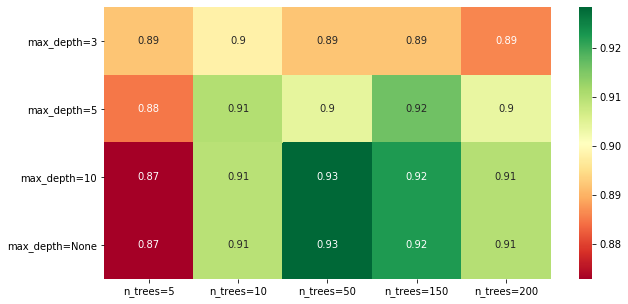

In [24]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(rf_df,annot=True,cmap="RdYlGn");

In [25]:
rf_clf.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [26]:
#Accuracy of classifier on test set:
rf = RandomForestClassifier(max_depth=10,n_estimators=50,random_state=0)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred_rf)
accuracy

0.9523809523809523

### Random Forest after feature selection:
Similar to the decision tree case, this is an attempt to improve the accuracy of the model.

Feature: 0, Score: 0.15451
Feature: 1, Score: 0.20580
Feature: 2, Score: 0.04133
Feature: 3, Score: 0.13011
Feature: 4, Score: 0.14622
Feature: 5, Score: 0.08937
Feature: 6, Score: 0.23265


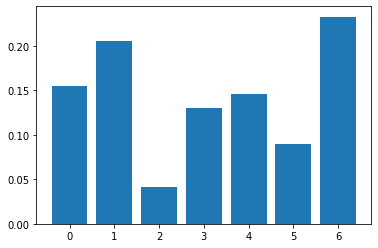

In [27]:
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

From the barplot however, it can be seen that the ranking of features is not as lopsided as in the case of the decision tree. So, feature removal is avoided.

## Gradient Tree Boosting:
The gradient tree boost classification is carried out through a sklearn.ensemble function GradientTreeClassifier. First, a baseline is taken and then the number of estimators parameter is tuned using GridSearchCV.

In [28]:
#Gradient Tree Boosting Baseline:
from sklearn.ensemble import GradientBoostingClassifier

gb0 = GradientBoostingClassifier(random_state=0)

gb_0 = gb0.fit(X_train,y_train)
y_0 = gb0.predict(X_test)
#Get accuracy score of model:
accuracy = metrics.accuracy_score(y_test,y_0)
accuracy

0.9523809523809523

In [31]:
#optimizing parameters for gradient tree boosting:
parameters = {'n_estimators':[5,10,50,150,200]}
gb = GradientBoostingClassifier(random_state=0)
gb_clf = GridSearchCV(gb,parameters,scoring='accuracy',cv=10)
gb_clf.fit(X_train,y_train)
means_gb = gb_clf.cv_results_['mean_test_score']


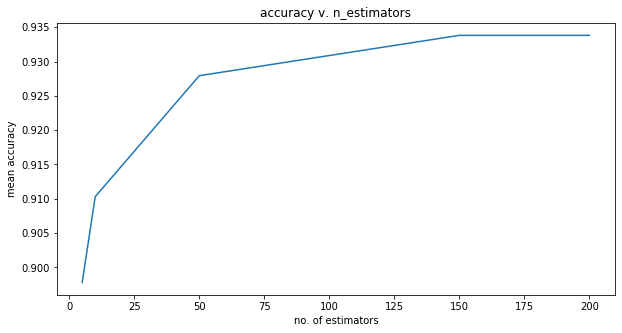

In [32]:
n_estimators = [5,10,50,150,200]
fig = plt.figure(figsize=(10,5))
plt.plot(n_estimators,means_gb)
plt.xlabel('no. of estimators')
plt.ylabel('mean accuracy')
plt.title('accuracy v. n_estimators');

From the plot above, it is clear that the mean accuracy increases quickly with the number of estimators but the growth tapers off as each additional estimator contributes lesser and lesser to the ensemble. In other words, increasing the number of trees improves the performance, which is as expected from the gradient boosting classifier, which is essentially a bunch of weak learners put together. According to the results of the grid search based on accuracy, the best number of trees for the given data is 150 out of the five choices.

In [33]:
gb_clf.best_params_

{'n_estimators': 150}

In [34]:
#Accuracy of classifier on test set:
y_pred_gb = gb_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred_gb)
accuracy

0.9523809523809523

## For Question 1, Part 2

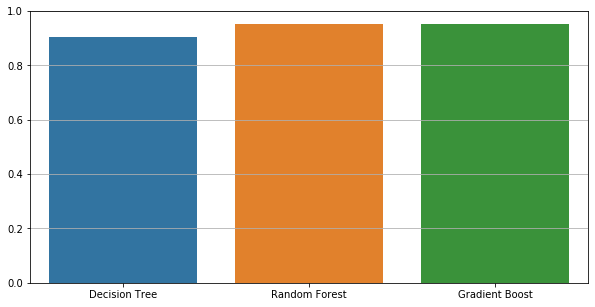

In [35]:
#Plot accuracies of each method in bar plot:
y1 = dt_clf.predict(X_test)
y2 = rf_clf.predict(X_test)
y3 = gb_clf.predict(X_test)
#Get accuracy score of models:
ac1 = metrics.accuracy_score(y_test,y1)
ac2 = metrics.accuracy_score(y_test,y2)
ac3 = metrics.accuracy_score(y_test,y3)
#Plot barplot:
fig = plt.figure(figsize=(10,5))
plt.grid(b=True)
meandata = pd.DataFrame([[ac1,ac2,ac3]],columns=['Decision Tree','Random Forest','Gradient Boost'])
ax = sns.barplot(data=meandata)

# Question 2:Naive Bayes Classification
## Part 1, Dataset 1(Wheat seeds)
This part of the assignment was done using the GaussianNB function from scikit-learn (sklearn.naive_bayes). The grid search was evaluated using the metrics library also from scikit-learn.
While there was no need for standardization for tree-based methods, the data is further preprocessed before being fed into the GaussianNB classifier.

In [36]:
#To normalize the datasets:
from sklearn.preprocessing import Normalizer
norm = Normalizer() #Works on each sample independantly and hence does not bias model towards testing set
n_X_train = norm.fit_transform(X_train)
n_X_test = norm.fit_transform(X_test)

In [37]:
#Baseline Naive Bayes:
from sklearn.naive_bayes import GaussianNB
gnb0 = GaussianNB()
y_pred0 = gnb0.fit(X_train, y_train).predict(X_test)
#Get accuracy score of model:
accuracy = metrics.accuracy_score(y_test,y_pred0)
accuracy

0.8571428571428571

### Results without normalization:

In [38]:
#Tuning Naive Bayes classifier parameters
parameters = {"var_smoothing":[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}
gnb = GaussianNB()
gnb_clf = GridSearchCV(gnb,parameters,scoring='accuracy',cv=10)
gnb_clf.fit(X_train,y_train)
means_gnb = gnb_clf.cv_results_['mean_test_score']

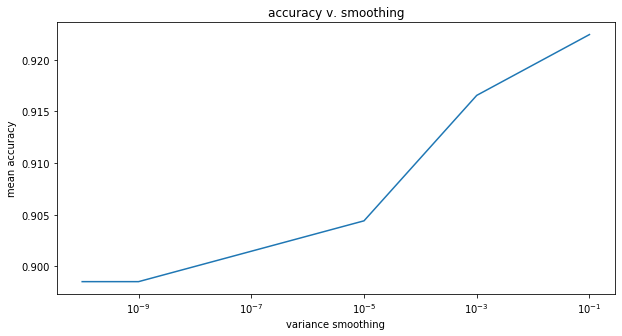

In [39]:
variance_smoothing=[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
fig = plt.figure(figsize=(10,5))
plt.plot(variance_smoothing,means_gnb)
plt.xscale('log')
plt.xlabel('variance smoothing')
plt.ylabel('mean accuracy')
plt.title('accuracy v. smoothing');

In [40]:
gnb_clf.best_params_

{'var_smoothing': 0.1}

In [41]:
yA = gnb_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test,yA)
accuracy

0.8571428571428571

### Results with normalization:

In [42]:
#Tuning Naive Bayes classifier parameters
parameters = {"var_smoothing":[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}
gnb = GaussianNB()
gnb_clf = GridSearchCV(gnb,parameters,scoring='accuracy',cv=10)
gnb_clf.fit(n_X_train,y_train)
means_gnb = gnb_clf.cv_results_['mean_test_score']

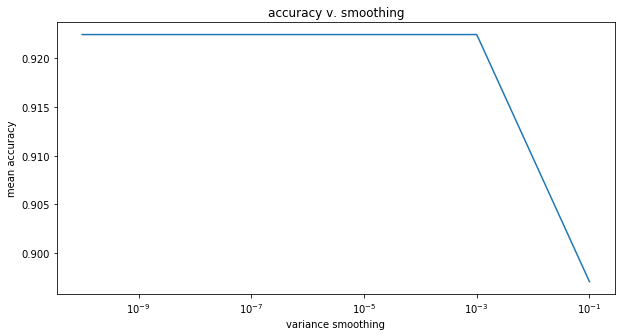

In [43]:
variance_smoothing=[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
fig = plt.figure(figsize=(10,5))
plt.plot(variance_smoothing,means_gnb)
plt.xscale('log')
plt.xlabel('variance smoothing')
plt.ylabel('mean accuracy')
plt.title('accuracy v. smoothing');

In [44]:
gnb_clf.best_params_

{'var_smoothing': 1e-10}

In [45]:
yA = gnb_clf.predict(n_X_test)
accuracy = metrics.accuracy_score(y_test,yA)
accuracy

0.8809523809523809

From the results of the test, normalization improved the accuracy of the model by ~3%, which is quite significant.

### Results after feature selection:

In [46]:
#Feature selection based on correlation table and decision tree:
X_train1 = X_train.drop(columns=['perimeter','compactness','width_kernel'])
X_test1 = X_test.drop(columns=['perimeter','compactness','width_kernel'])

In [47]:
#Tuning Naive Bayes classifier parameters
parameters = {"var_smoothing":[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}
gnb = GaussianNB()
gnb_clf = GridSearchCV(gnb,parameters,scoring='accuracy',cv=10)
gnb_clf.fit(X_train1,y_train)
means_gnb = gnb_clf.cv_results_['mean_test_score']

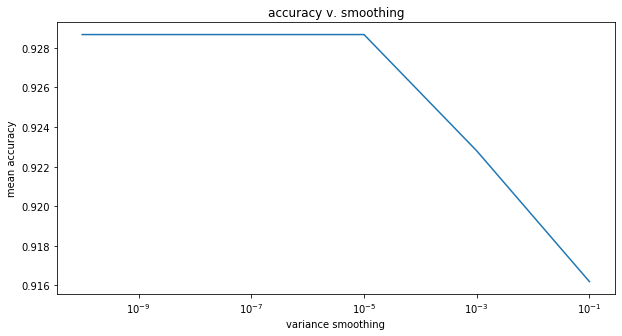

In [48]:
variance_smoothing=[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
fig = plt.figure(figsize=(10,5))
plt.plot(variance_smoothing,means_gnb)
plt.xscale('log')
plt.xlabel('variance smoothing')
plt.ylabel('mean accuracy')
plt.title('accuracy v. smoothing');

In [49]:
gnb_clf.best_params_

{'var_smoothing': 1e-10}

In [50]:
yA = gnb_clf.predict(X_test1)
accuracy = metrics.accuracy_score(y_test,yA)
accuracy

0.9285714285714286

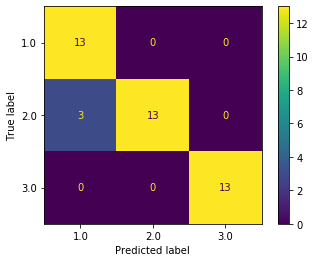

In [62]:
#Confusion matrix for Naive Bayes
cm = metrics.confusion_matrix(y_test, yA,labels=gnb_clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb_clf.classes_)
disp.plot();

From the above value of accuracy on test set, it is clear that removing highly correlated features (with a good chance of being dependant on each other) is healthy for a good Naive Bayes model.

### Impact of variance smoothing: 
By specifying a value for var_smoothing, we are adding artificial variance to the natural variance of the distribution, thereby accounting for majority of the data, "smoothing" out the curve and blurring existing boundaries. In the case of Dataset 1, before normalization, due to the distribution of the data not being normal, increase in var_smoothing improved mean_accuracy, but was also accounting for increased false positives. On the other hand, after normalization, the variance smoothing upto 0.1 had nearly no effect as the data was already quite normal and did not need "help" from var_smoothing to fit into the classes. Towards higher values of var_smoothing, the accuracy sharply decreased, which fits in well with the theory. 